# Part A — Install & Setup

In [4]:
# Part A - Install & Setup
# Run this cell first in Colab to install dependencies

# If you already installed some packages, you can skip installs as needed
# !pip install -q scikit-learn xgboost catboost joblib pandas numpy

# Standard imports and config
import os, json, joblib, numpy as np, pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Optional imports (after pip install)
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Paths - update DATA_PATH if needed
DATA_PATH = "synthetic_asd_children_2000_noisy.csv"   # <<-- upload file here in Colab
OUTPUT_DIR = "/content/asd_model_output"
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# Column lists (from previous design)
Q_COLS = [f"Q{i}" for i in range(1,31)]
META_COLS = ["child_id","age","sex","urban_rural","siblings_asd","speech_delay","parental_concern"]
TARGET_COL = "risk_label"
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


#Part B — Load data & basic checks

In [5]:
# Part B - Load data & basic checks with comprehensive preprocessing
df = pd.read_csv(DATA_PATH)
print("Original data - Rows:", len(df), "Columns:", df.shape[1])
print("\nInitial column types:")
print(df.dtypes)

# ============================================
# DATA PREPROCESSING & CLEANING
# ============================================

# 1. Handle missing values
print("\n=== Missing Values Check ===")
missing_counts = df.isnull().sum()
if missing_counts.sum() > 0:
    print("Missing values found:")
    print(missing_counts[missing_counts > 0])
    
    # Fill missing values with appropriate defaults
    for col in Q_COLS:
        if col in df.columns and df[col].isnull().any():
            df[col].fillna(0, inplace=True)
    
    if 'age' in df.columns and df['age'].isnull().any():
        df['age'].fillna(df['age'].median(), inplace=True)
    
    if 'siblings_asd' in df.columns and df['siblings_asd'].isnull().any():
        df['siblings_asd'].fillna(0, inplace=True)
    
    if 'speech_delay' in df.columns and df['speech_delay'].isnull().any():
        df['speech_delay'].fillna(0, inplace=True)
    
    if 'parental_concern' in df.columns and df['parental_concern'].isnull().any():
        df['parental_concern'].fillna('low', inplace=True)
    
    if 'sex' in df.columns and df['sex'].isnull().any():
        df['sex'].fillna(df['sex'].mode()[0], inplace=True)
    
    if 'urban_rural' in df.columns and df['urban_rural'].isnull().any():
        df['urban_rural'].fillna(df['urban_rural'].mode()[0], inplace=True)
    
    print("✓ Missing values handled")
else:
    print("No missing values found")

# 2. Convert data types
print("\n=== Data Type Conversion ===")
for c in Q_COLS:
    if c in df.columns:
        df[c] = df[c].astype(int)

df['age'] = df['age'].astype(int)
df['siblings_asd'] = df['siblings_asd'].astype(int)
df['speech_delay'] = df['speech_delay'].astype(int)

# Ensure categorical variables are lowercase and standardized
df['parental_concern'] = df['parental_concern'].astype(str).str.lower().str.strip()
df['sex'] = df['sex'].astype(str).str.lower().str.strip()
df['urban_rural'] = df['urban_rural'].astype(str).str.lower().str.strip()
df[TARGET_COL] = df[TARGET_COL].astype(str).str.lower().str.strip()

print("✓ Data types converted")

# 3. Validate categorical values
print("\n=== Categorical Values Validation ===")
print("Sex values:", df['sex'].unique())
print("Urban/Rural values:", df['urban_rural'].unique())
print("Parental Concern values:", df['parental_concern'].unique())
print("Target (risk_label) values:", df[TARGET_COL].unique())

# Fix any inconsistent categorical values
df['sex'] = df['sex'].replace({'m': 'male', 'f': 'female'})
df['urban_rural'] = df['urban_rural'].replace({'u': 'urban', 'r': 'rural'})
df['parental_concern'] = df['parental_concern'].replace({'l': 'low', 'm': 'medium', 'h': 'high'})

# 4. Validate binary and numeric ranges
print("\n=== Data Range Validation ===")
print(f"Age range: {df['age'].min()} - {df['age'].max()}")
print(f"Siblings ASD: {df['siblings_asd'].unique()}")
print(f"Speech Delay: {df['speech_delay'].unique()}")

# Ensure binary columns are 0 or 1
for col in ['siblings_asd', 'speech_delay'] + Q_COLS:
    if col in df.columns:
        df[col] = df[col].clip(0, 1)

# Ensure age is within reasonable bounds (4-11 years for children)
df['age'] = df['age'].clip(4, 11)

print("✓ Data ranges validated")

# 5. Remove duplicates if any
print("\n=== Duplicate Check ===")
duplicates = df.duplicated().sum()
if duplicates > 0:
    print(f"Found {duplicates} duplicate rows - removing...")
    df = df.drop_duplicates()
    print("✓ Duplicates removed")
else:
    print("No duplicates found")

# 6. Final dataset info
print("\n" + "="*50)
print("PREPROCESSED DATASET SUMMARY")
print("="*50)
print(f"Final shape: {df.shape}")
print(f"\nClass distribution:")
print(df[TARGET_COL].value_counts(normalize=True).round(3))
print(f"\nSample of preprocessed data:")
display(df.head())

print("\n✓ Data preprocessing complete!")

Original data - Rows: 2000 Columns: 40

Initial column types:
child_id             object
Q1                    int64
Q2                    int64
Q3                    int64
Q4                    int64
Q5                    int64
Q6                    int64
Q7                    int64
Q8                    int64
Q9                    int64
Q10                   int64
Q11                   int64
Q12                   int64
Q13                   int64
Q14                   int64
Q15                   int64
Q16                   int64
Q17                   int64
Q18                   int64
Q19                   int64
Q20                   int64
Q21                   int64
Q22                   int64
Q23                   int64
Q24                   int64
Q25                   int64
Q26                   int64
Q27                   int64
Q28                   int64
Q29                   int64
Q30                   int64
age                   int64
sex                  object
urban_rural   

,child_id,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,...,Q30,age,sex,urban_rural,siblings_asd,speech_delay,parental_concern,raw_score,adjusted_score,risk_label
0,C0001,1,1,1,1,0,1,1,0,0,...,1,8,male,urban,0,0,low,65,79.18,high
1,C0002,0,1,1,0,1,1,1,1,0,...,0,5,male,rural,0,0,medium,67,73.51,high
2,C0003,0,1,0,0,0,0,1,0,0,...,0,5,male,urban,0,0,medium,16,20.00,low
3,C0004,0,0,1,0,0,0,1,0,0,...,0,7,female,urban,0,0,low,24,22.45,low
4,C0005,1,1,1,0,1,0,1,0,1,...,0,8,female,rural,0,0,low,50,57.50,moderate



✓ Data preprocessing complete!


In [6]:
# Part B.1 - Feature Engineering & Advanced Preprocessing

# ============================================
# FEATURE ENGINEERING
# ============================================

print("=== Feature Engineering ===")

# 1. Calculate raw screening scores by category
df['social_communication_score'] = df[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6']].sum(axis=1)
df['verbal_nonverbal_score'] = df[['Q7', 'Q8', 'Q9', 'Q10', 'Q11']].sum(axis=1)
df['behaviour_routine_score'] = df[['Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17']].sum(axis=1)
df['sensory_processing_score'] = df[['Q18', 'Q19', 'Q20', 'Q21', 'Q22']].sum(axis=1)
df['motor_skills_score'] = df[['Q23', 'Q24', 'Q25', 'Q26']].sum(axis=1)
df['emotional_understanding_score'] = df[['Q27', 'Q28', 'Q29', 'Q30']].sum(axis=1)

# 2. Calculate total raw score
df['total_raw_score'] = df[[f'Q{i}' for i in range(1, 31)]].sum(axis=1)

# 3. Calculate normalized scores (percentage)
df['social_communication_pct'] = (df['social_communication_score'] / 6 * 100).round(2)
df['verbal_nonverbal_pct'] = (df['verbal_nonverbal_score'] / 5 * 100).round(2)
df['behaviour_routine_pct'] = (df['behaviour_routine_score'] / 6 * 100).round(2)
df['sensory_processing_pct'] = (df['sensory_processing_score'] / 5 * 100).round(2)
df['motor_skills_pct'] = (df['motor_skills_score'] / 4 * 100).round(2)
df['emotional_understanding_pct'] = (df['emotional_understanding_score'] / 4 * 100).round(2)
df['total_score_pct'] = (df['total_raw_score'] / 30 * 100).round(2)

# 4. Create risk indicators based on domain scores
# High concern if score in domain is >= 70% positive responses
df['high_social_concern'] = (df['social_communication_pct'] >= 70).astype(int)
df['high_communication_concern'] = (df['verbal_nonverbal_pct'] >= 70).astype(int)
df['high_behaviour_concern'] = (df['behaviour_routine_pct'] >= 70).astype(int)
df['high_sensory_concern'] = (df['sensory_processing_pct'] >= 70).astype(int)
df['high_motor_concern'] = (df['motor_skills_pct'] >= 70).astype(int)
df['high_emotional_concern'] = (df['emotional_understanding_pct'] >= 70).astype(int)

# 5. Count number of high concern domains
df['num_high_concern_domains'] = df[[
    'high_social_concern', 'high_communication_concern', 
    'high_behaviour_concern', 'high_sensory_concern',
    'high_motor_concern', 'high_emotional_concern'
]].sum(axis=1)

# 6. Create interaction features
df['age_speech_interaction'] = df['age'] * df['speech_delay']
df['sibling_concern_interaction'] = df['siblings_asd'] * (df['parental_concern'] == 'high').astype(int)

# 7. Encode parental concern as numeric for some features
parental_concern_map = {'low': 0, 'medium': 1, 'high': 2}
df['parental_concern_numeric'] = df['parental_concern'].map(parental_concern_map)

print("✓ Feature engineering complete")
print(f"\nNew features created:")
print("  - Category scores (6 categories)")
print("  - Percentage scores (7 percentages)")
print("  - High concern indicators (6 binary)")
print("  - Domain concern count")
print("  - Interaction features (2)")
print("  - Parental concern numeric")

print(f"\nTotal features now: {df.shape[1]}")

# Display sample of engineered features
print("\nSample of engineered features:")
display(df[['total_raw_score', 'total_score_pct', 'num_high_concern_domains', 
            'social_communication_score', 'sensory_processing_score']].head())

# Statistics by risk label
print("\n=== Feature Statistics by Risk Label ===")
for label in df[TARGET_COL].unique():
    subset = df[df[TARGET_COL] == label]
    print(f"\n{label.upper()} risk (n={len(subset)}):")
    print(f"  Mean total score: {subset['total_raw_score'].mean():.2f}")
    print(f"  Mean score %: {subset['total_score_pct'].mean():.2f}%")
    print(f"  Mean high concern domains: {subset['num_high_concern_domains'].mean():.2f}")

=== Feature Engineering ===
✓ Feature engineering complete

New features created:
  - Category scores (6 categories)
  - Percentage scores (7 percentages)
  - High concern indicators (6 binary)
  - Domain concern count
  - Interaction features (2)
  - Parental concern numeric

Total features now: 64

Sample of engineered features:


,total_raw_score,total_score_pct,num_high_concern_domains,social_communication_score,sensory_processing_score
0,20,66.67,4,5,4
1,19,63.33,2,4,3
2,4,13.33,0,1,0
3,7,23.33,0,1,1
4,14,46.67,0,4,1



=== Feature Statistics by Risk Label ===

HIGH risk (n=711):
  Mean total score: 20.61
  Mean score %: 68.70%
  Mean high concern domains: 3.11

LOW risk (n=566):
  Mean total score: 6.03
  Mean score %: 20.09%
  Mean high concern domains: 0.14

MODERATE risk (n=723):
  Mean total score: 12.96
  Mean score %: 43.19%
  Mean high concern domains: 1.05


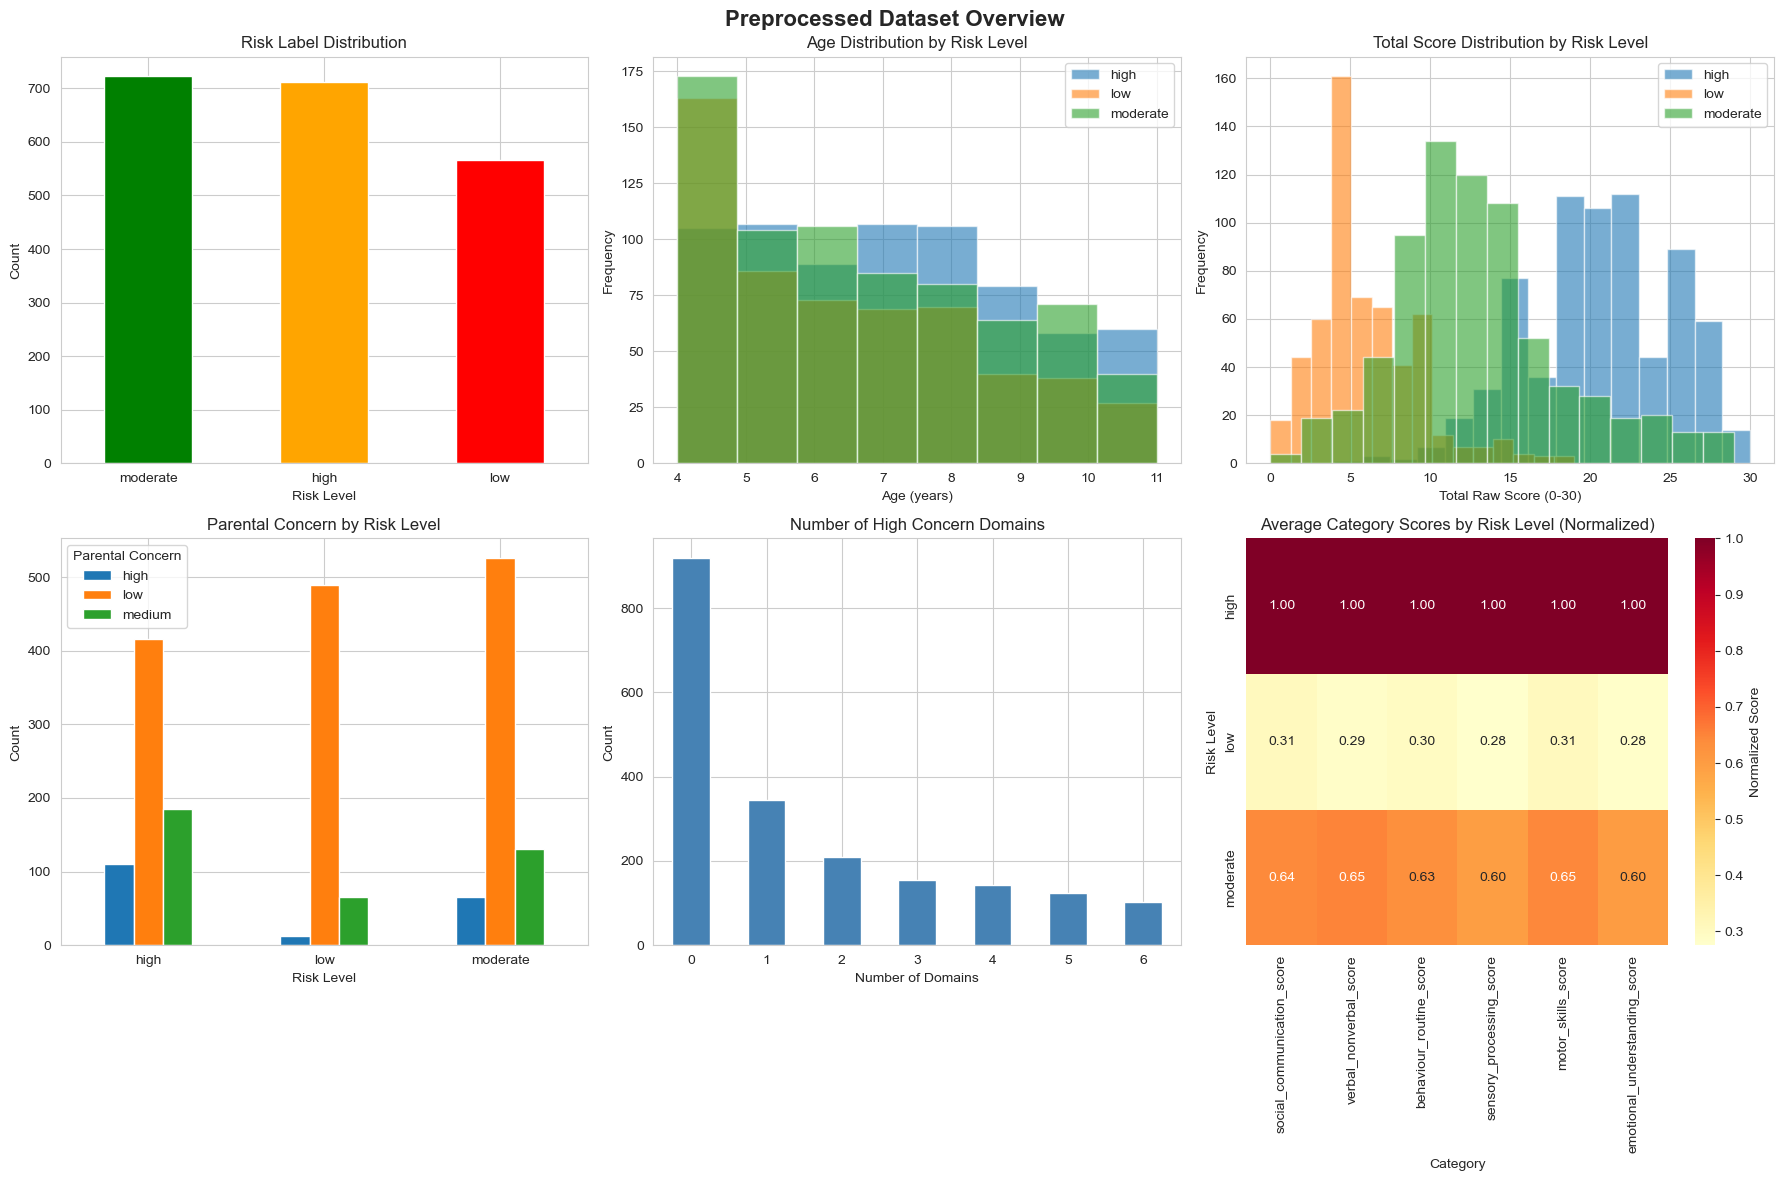

✓ Visualization complete


In [7]:
# Part B.2 - Data Quality Visualization (Optional)

import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Preprocessed Dataset Overview', fontsize=16, fontweight='bold')

# 1. Class distribution
ax1 = axes[0, 0]
df[TARGET_COL].value_counts().plot(kind='bar', ax=ax1, color=['green', 'orange', 'red'])
ax1.set_title('Risk Label Distribution')
ax1.set_xlabel('Risk Level')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=0)

# 2. Age distribution by risk
ax2 = axes[0, 1]
for label in df[TARGET_COL].unique():
    subset = df[df[TARGET_COL] == label]
    ax2.hist(subset['age'], alpha=0.6, label=label, bins=8)
ax2.set_title('Age Distribution by Risk Level')
ax2.set_xlabel('Age (years)')
ax2.set_ylabel('Frequency')
ax2.legend()

# 3. Total score distribution
ax3 = axes[0, 2]
for label in df[TARGET_COL].unique():
    subset = df[df[TARGET_COL] == label]
    ax3.hist(subset['total_raw_score'], alpha=0.6, label=label, bins=15)
ax3.set_title('Total Score Distribution by Risk Level')
ax3.set_xlabel('Total Raw Score (0-30)')
ax3.set_ylabel('Frequency')
ax3.legend()

# 4. Categorical variables distribution
ax4 = axes[1, 0]
cat_data = df.groupby([TARGET_COL, 'parental_concern']).size().unstack(fill_value=0)
cat_data.plot(kind='bar', ax=ax4, stacked=False)
ax4.set_title('Parental Concern by Risk Level')
ax4.set_xlabel('Risk Level')
ax4.set_ylabel('Count')
ax4.tick_params(axis='x', rotation=0)
ax4.legend(title='Parental Concern')

# 5. High concern domains
ax5 = axes[1, 1]
concern_counts = df['num_high_concern_domains'].value_counts().sort_index()
concern_counts.plot(kind='bar', ax=ax5, color='steelblue')
ax5.set_title('Number of High Concern Domains')
ax5.set_xlabel('Number of Domains')
ax5.set_ylabel('Count')
ax5.tick_params(axis='x', rotation=0)

# 6. Category scores heatmap
ax6 = axes[1, 2]
category_scores = df.groupby(TARGET_COL)[[
    'social_communication_score', 'verbal_nonverbal_score',
    'behaviour_routine_score', 'sensory_processing_score',
    'motor_skills_score', 'emotional_understanding_score'
]].mean()
category_scores_norm = category_scores.div(category_scores.max(axis=0), axis=1)
sns.heatmap(category_scores_norm, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax6, cbar_kws={'label': 'Normalized Score'})
ax6.set_title('Average Category Scores by Risk Level (Normalized)')
ax6.set_xlabel('Category')
ax6.set_ylabel('Risk Level')

plt.tight_layout()
plt.show()

print("✓ Visualization complete")

#Part C — Train / Val / Test split

In [8]:
# Part C - Train / Validation / Test split (70/15/15)

# Define which features to use for modeling
# Option 1: Use only Q1-Q30 + basic demographics (baseline model)
# Option 2: Include engineered features for potentially better performance

# Choose feature set (change to True/False as needed)
USE_ENGINEERED_FEATURES = True

if USE_ENGINEERED_FEATURES:
    # Include category scores and other engineered features
    feature_cols = [c for c in df.columns if c not in [
        TARGET_COL, "child_id", 
        # Exclude raw category scores if you want, or keep them
        # "social_communication_score", "verbal_nonverbal_score", etc.
    ]]
    print("Using ENHANCED feature set with engineered features")
else:
    # Use only original features (Q1-Q30 + demographics)
    feature_cols = Q_COLS + ["age", "sex", "urban_rural", "siblings_asd", "speech_delay", "parental_concern"]
    print("Using BASELINE feature set (original features only)")

X = df[feature_cols]
y = df[TARGET_COL].values

print(f"Features selected: {len(feature_cols)} columns")
print(f"Target variable: {TARGET_COL}")

# First split: train / temp (70% / 30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE
)

# Split temp into val/test equally (15% / 15% of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=RANDOM_STATE
)

print(f"\n✓ Data split complete:")
print(f"  Training set: {len(X_train)} samples ({len(X_train)/len(df)*100:.1f}%)")
print(f"  Validation set: {len(X_val)} samples ({len(X_val)/len(df)*100:.1f}%)")
print(f"  Test set: {len(X_test)} samples ({len(X_test)/len(df)*100:.1f}%)")

# Verify stratification
print(f"\n✓ Class distribution verification:")
print(f"  Original: {pd.Series(y).value_counts(normalize=True).to_dict()}")
print(f"  Train: {pd.Series(y_train).value_counts(normalize=True).to_dict()}")
print(f"  Val: {pd.Series(y_val).value_counts(normalize=True).to_dict()}")
print(f"  Test: {pd.Series(y_test).value_counts(normalize=True).to_dict()}")

Using ENHANCED feature set with engineered features
Features selected: 62 columns
Target variable: risk_label

✓ Data split complete:
  Training set: 1400 samples (70.0%)
  Validation set: 300 samples (15.0%)
  Test set: 300 samples (15.0%)

✓ Class distribution verification:
  Original: {'moderate': 0.3615, 'high': 0.3555, 'low': 0.283}
  Train: {'moderate': 0.36142857142857143, 'high': 0.3557142857142857, 'low': 0.28285714285714286}
  Val: {'moderate': 0.36333333333333334, 'high': 0.35333333333333333, 'low': 0.2833333333333333}
  Test: {'moderate': 0.36, 'high': 0.3566666666666667, 'low': 0.2833333333333333}


#Part D — Preprocessing pipeline (Ordinal + OneHot + Scaler) & metadata save

In [9]:
# Part D - Build Preprocessor & save metadata

# ============================================
# PREPROCESSING PIPELINE SETUP
# ============================================

print("=== Building Preprocessing Pipeline ===")

# 1) Identify column types in the current feature set
numeric_cols = []
ordinal_cols = []
ohe_cols = []

for col in X_train.columns:
    if col in Q_COLS:
        # Questions are binary numeric
        numeric_cols.append(col)
    elif col in ['age', 'siblings_asd', 'speech_delay']:
        # Basic demographics that are numeric
        numeric_cols.append(col)
    elif col.endswith('_score') or col.endswith('_pct') or col.endswith('_numeric') or col.endswith('_interaction'):
        # Engineered numeric features
        numeric_cols.append(col)
    elif col.startswith('high_') or col == 'num_high_concern_domains':
        # Binary indicators
        numeric_cols.append(col)
    elif col == 'parental_concern':
        # Ordinal encoding for parental_concern (low < medium < high)
        ordinal_cols.append(col)
    elif col in ['sex', 'urban_rural']:
        # One-hot encoding for nominal categories
        ohe_cols.append(col)
    else:
        # Any other column gets included as numeric
        numeric_cols.append(col)

print(f"Numeric columns: {len(numeric_cols)}")
print(f"Ordinal columns: {len(ordinal_cols)}")
print(f"OneHot columns: {len(ohe_cols)}")

# 2) Create transformers
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

transformers = []

# Ordinal encoding for parental_concern
if ordinal_cols:
    ord_enc = OrdinalEncoder(categories=[['low', 'medium', 'high']], dtype=int, handle_unknown='use_encoded_value', unknown_value=-1)
    transformers.append(("ord", ord_enc, ordinal_cols))
    print(f"  ✓ Ordinal encoder added for: {ordinal_cols}")

# One-hot encoding for sex and urban_rural
if ohe_cols:
    ohe_enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop='first')  # drop first to avoid multicollinearity
    transformers.append(("ohe", ohe_enc, ohe_cols))
    print(f"  ✓ OneHot encoder added for: {ohe_cols}")

# Standard scaling for numeric features
if numeric_cols:
    scaler = StandardScaler()
    transformers.append(("num", scaler, numeric_cols))
    print(f"  ✓ Standard scaler added for {len(numeric_cols)} numeric columns")

# 3) Build the column transformer
preprocessor = ColumnTransformer(
    transformers=transformers,
    remainder="drop",  # Drop any columns not specified
    verbose_feature_names_out=False
)

# 4) Fit preprocessor on training data only (avoid data leakage)
print("\nFitting preprocessor on training data...")
preprocessor.fit(X_train)
print("✓ Preprocessor fitted")

# 5) Get feature names after transformation
try:
    transformed_feature_names = preprocessor.get_feature_names_out()
    print(f"✓ Output features after preprocessing: {len(transformed_feature_names)}")
except Exception as e:
    print(f"Note: Could not retrieve feature names: {e}")
    transformed_feature_names = None

# 6) Save preprocessor and metadata
joblib.dump(preprocessor, os.path.join(OUTPUT_DIR, "preprocessor.pkl"))
print(f"✓ Saved preprocessor.pkl")

# Save input feature columns (expected order for new data)
feature_columns = list(X_train.columns)
with open(os.path.join(OUTPUT_DIR, "feature_columns.json"), "w") as f:
    json.dump(feature_columns, f, indent=2)
print(f"✓ Saved feature_columns.json ({len(feature_columns)} input features)")

# Save output feature names if available
if transformed_feature_names is not None:
    with open(os.path.join(OUTPUT_DIR, "transformed_feature_names.json"), "w") as f:
        json.dump(list(transformed_feature_names), f, indent=2)
    print(f"✓ Saved transformed_feature_names.json ({len(transformed_feature_names)} output features)")

# 7) Test transformation on a small sample
print("\n=== Testing Preprocessing ===")
X_train_transformed = preprocessor.transform(X_train[:5])
print(f"Sample input shape: (5, {X_train.shape[1]})")
print(f"Sample output shape: {X_train_transformed.shape}")
print("✓ Preprocessing pipeline working correctly")

=== Building Preprocessing Pipeline ===
Numeric columns: 59
Ordinal columns: 1
OneHot columns: 2
  ✓ Ordinal encoder added for: ['parental_concern']
  ✓ OneHot encoder added for: ['sex', 'urban_rural']
  ✓ Standard scaler added for 59 numeric columns

Fitting preprocessor on training data...
✓ Preprocessor fitted
✓ Output features after preprocessing: 62
✓ Saved preprocessor.pkl
✓ Saved feature_columns.json (62 input features)
✓ Saved transformed_feature_names.json (62 output features)

=== Testing Preprocessing ===
Sample input shape: (5, 62)
Sample output shape: (5, 62)
✓ Preprocessing pipeline working correctly


In [10]:
# Encode target labels into integers (0,1,2). Run after you've created X_train, X_val, X_test, y_train, y_val, y_test
from sklearn.preprocessing import LabelEncoder
import joblib, os

# Fit label encoder only on training labels (prevents leakage)
le = LabelEncoder()
le.fit(y_train)   # y_train are string labels: 'low','moderate','high'

# Transform all splits
y_train_enc = le.transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

# Save encoder for deployment
joblib.dump(le, os.path.join(OUTPUT_DIR, "label_encoder.pkl"))
print("Saved label_encoder.pkl with classes:", le.classes_)


Saved label_encoder.pkl with classes: ['high' 'low' 'moderate']


#Part E — Train Models (RandomForest, XGBoost, CatBoost)

In [11]:
# Retrain models using numeric labels (y_train_enc). This will overwrite previous pipelines if you re-use same names.
from sklearn.pipeline import Pipeline
import joblib, os

def train_and_save_enc(model, model_name, X_tr=X_train, y_tr=y_train_enc):
    pipe = Pipeline(steps=[("pre", preprocessor), ("clf", model)])
    pipe.fit(X_tr, y_tr)
    path = os.path.join(OUTPUT_DIR, f"{model_name}_pipeline.pkl")
    joblib.dump(pipe, path)
    print(f"Saved {model_name} pipeline -> {path}")
    return pipe

# RandomForest (retrain with encoded labels)
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
rf_pipe = train_and_save_enc(rf, "random_forest_enc")

# XGBoost
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_STATE)
xgb_pipe = train_and_save_enc(xgb, "xgboost_enc")

# CatBoost
from catboost import CatBoostClassifier
cb = CatBoostClassifier(iterations=300, verbose=0, random_state=RANDOM_STATE)
cb_pipe = train_and_save_enc(cb, "catboost_enc")


Saved random_forest_enc pipeline -> /content/asd_model_output\random_forest_enc_pipeline.pkl


d:\Users\Prajj\miniforge3\envs\ml\Lib\site-packages\xgboost\training.py:199: UserWarning: [00:38:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Saved xgboost_enc pipeline -> /content/asd_model_output\xgboost_enc_pipeline.pkl
Saved catboost_enc pipeline -> /content/asd_model_output\catboost_enc_pipeline.pkl


In [13]:
# Evaluate encoded models and show classification reports with original label names
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import numpy as np

models_enc = {"random_forest": rf_pipe, "xgboost": xgb_pipe, "catboost": cb_pipe}

def evaluate_enc(pipe, X, y_true_enc):
    y_pred_enc = pipe.predict(X)
    acc = accuracy_score(y_true_enc, y_pred_enc)
    f1m = f1_score(y_true_enc, y_pred_enc, average='macro')
    report = classification_report(y_true_enc, y_pred_enc, target_names=list(le.classes_), zero_division=0)
    cm = confusion_matrix(y_true_enc, y_pred_enc)
    return {"accuracy": acc, "f1_macro": f1m, "report": report, "confusion_matrix": cm, "y_pred_enc": y_pred_enc}

# Validation
val_results = {}
for name, p in models_enc.items():
    res = evaluate_enc(p, X_val, y_val_enc)
    val_results[name] = res
    print(f"=== {name} VALIDATION ===")
    print("Accuracy:", res['accuracy'], "F1-macro:", res['f1_macro'])
    print(res['report'])

# Select best by f1_macro
best_name = max(val_results.items(), key=lambda kv: kv[1]['f1_macro'])[0]
print("Best on validation (encoded):", best_name)

# Test evaluation (decoded reporting)
best_model_enc = models_enc[best_name]
test_res = evaluate_enc(best_model_enc, X_test, y_test_enc)
print(f"=== {best_name} TEST ===")
print("Accuracy:", test_res['accuracy'], "F1-macro:", test_res['f1_macro'])
print(test_res['report'])

# Save best model as final_model_pipeline.pkl (encoded)
final_path = os.path.join(OUTPUT_DIR, "final_model_pipeline.pkl")
joblib.dump(best_model_enc, final_path)
print("Saved final model pipeline as:", final_path)


=== random_forest VALIDATION ===
Accuracy: 0.7733333333333333 F1-macro: 0.7751322751322752
              precision    recall  f1-score   support

        high       0.83      0.86      0.84       106
         low       0.81      0.79      0.80        85
    moderate       0.69      0.68      0.69       109

    accuracy                           0.77       300
   macro avg       0.78      0.78      0.78       300
weighted avg       0.77      0.77      0.77       300

=== xgboost VALIDATION ===
Accuracy: 0.7766666666666666 F1-macro: 0.7766846161968113
              precision    recall  f1-score   support

        high       0.82      0.88      0.85       106
         low       0.79      0.84      0.81        85
    moderate       0.72      0.63      0.67       109

    accuracy                           0.78       300
   macro avg       0.77      0.78      0.78       300
weighted avg       0.77      0.78      0.77       300

=== catboost VALIDATION ===
Accuracy: 0.78 F1-macro: 0.7819269

In [11]:
# Example: make a single prediction and decode label back to readable string
import pandas as pd, joblib, json, os
pipeline = joblib.load(os.path.join(OUTPUT_DIR, "final_model_pipeline.pkl"))
le = joblib.load(os.path.join(OUTPUT_DIR, "label_encoder.pkl"))
features = json.load(open(os.path.join(OUTPUT_DIR, "feature_columns.json")))

def preprocess_input_dict(input_dict):
    row = {f: None for f in features}
    row.update(input_dict)
    for q in Q_COLS:
        if row.get(q) is None:
            row[q] = 0
    if row.get("age") is None: row["age"] = 5
    if row.get("siblings_asd") is None: row["siblings_asd"] = 0
    if row.get("speech_delay") is None: row["speech_delay"] = 0
    if row.get("parental_concern") is None: row["parental_concern"] = "low"
    if row.get("sex") is None: row["sex"] = "male"
    if row.get("urban_rural") is None: row["urban_rural"] = "urban"
    return pd.DataFrame([row])[features]

def predict_single_decoded(input_dict):
    X_new = preprocess_input_dict(input_dict)
    pred_enc = pipeline.predict(X_new)[0]
    try:
        proba = pipeline.predict_proba(X_new)[0].tolist()
    except Exception:
        proba = None
    pred_label = le.inverse_transform([pred_enc])[0]
    return {"prediction": pred_label, "probabilities": proba}

# Example usage (same example child as earlier)
example_child = {
    "Q1":1,"Q2":0,"Q3":1,"Q4":0,"Q5":1,"Q6":0,
    "Q7":0,"Q8":0,"Q9":1,"Q10":0,"Q11":0,
    "Q12":0,"Q13":0,"Q14":1,"Q15":0,"Q16":0,"Q17":0,
    "Q18":1,"Q19":0,"Q20":0,"Q21":0,"Q22":0,
    "Q23":0,"Q24":0,"Q25":0,"Q26":0,"Q27":1,"Q28":0,"Q29":0,"Q30":0,
    "age":6,"sex":"male","urban_rural":"urban","siblings_asd":0,"speech_delay":0,"parental_concern":"low"
}
print("Decoded prediction:", predict_single_decoded(example_child))


Decoded prediction: {'prediction': 'moderate', 'probabilities': [0.215, 0.365, 0.42]}


In [12]:
# ZIP the entire folder
!zip -r /content/asd_model_output.zip /content/asd_model_output

# Download ZIP to your local device
from google.colab import files
files.download('/content/asd_model_output.zip')


  adding: content/asd_model_output/ (stored 0%)
  adding: content/asd_model_output/preprocessor.pkl (deflated 53%)
  adding: content/asd_model_output/feature_columns.json (deflated 60%)
  adding: content/asd_model_output/random_forest_pipeline.pkl (deflated 83%)
  adding: content/asd_model_output/catboost_enc_pipeline.pkl (deflated 76%)
  adding: content/asd_model_output/random_forest_enc_pipeline.pkl (deflated 83%)
  adding: content/asd_model_output/final_model_pipeline.pkl (deflated 83%)
  adding: content/asd_model_output/xgboost_enc_pipeline.pkl (deflated 94%)
  adding: content/asd_model_output/label_encoder.pkl (deflated 34%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>